In [1]:
import oyster as oy

## Table of Contents
- [Introduction](#intro)
- [Preliminaries](#prelim)
    - [Study question 1.4.1](#sq141)
    - [Study question 1.5.1](#sq151)
        - [Causal diagrams as a useful, high-level abstraction](#abstraction)
- [Graphical Models and Their Applications](#graphsAndApps)
    - [Study question 2.3.1](#sq231)
        - [D-Separation](#d_sep_graph)
    - [Study question 2.4.1](#sq241)
        - [Implied Independencies as Testable Implications](#impliedIndependencies)
        - [Minimal Separating Sets to Maximize Sample Size](#minsets)
        - [Markov Blankets as Optimal Predictors](#mb)
        - [Causal Diagram Analysis for Variable Selection](#variableSelection)
    - [Study question 2.5.1](#sq251)
- [The Effects of Interventions](#interventions)
    - [Study question 3.3.1](#sq331)
    - [Study question 3.5.1](#sq351)

# Introduction <a id="intro"></a>
Learn Oyster in this walkthrough of selected examples from Judea Pearl's *Causal Inference in Statistics: A Primer*.  Credit to Johannes Textor, Andrew Forney, and Judea Pearl for [their approach](http://dagitty.net/primer/) to teaching the R package Daggity.  This walkthrough focuses on study questions that are graphical in nature, so it skips several questions from the primer as well as some questions addressed in Textor's walkthrough, while adding a couple others.  Along the way, I try to convey some of the key insights I learned from the Primer in my own words.  These are usually keyed with ***bold italics*** and are linked at the third indent level in the above table of contents.

### Study Question 1.4.1 <a id="sq141"></a>
#### Consider the graph shown in Figure 1.8...

In Oyster, causal diagrams (Pearl often calls them simply "Graphs" or "Directed Acyclic Graphs (DAGs)"; so will we) are instances of the `CausalDiagram` class. The easiest way to initialize a `CausalDiagram` is by providing a list of two-tuples corresponding to the edges in the graph.  Order is important, as the edges are directed from the first node in the tuple to the second.

In [2]:
fig1_8 = oy.CausalDiagram(([('X', 'W'), ('X', 'Y'), 
                            ('W', 'Y'), ('W', 'Z'), 
                            ('Y', 'T'), ('Y', 'Z'), 
                            ('Z', 'T')]))

CausalDiagram subclasses the DiGraph class in the excellent [NetworkX](https://networkx.github.io) package, so many methods and attributes from `networkx.DiGraph` are available in `oyster.CausalDiagram`. In fact, Oyster relies on NetworkX for most of its backend, so many thanks to the NetworkX team.

In [3]:
fig1_8.nodes # the set of nodes in fig1_8

NodeView(('X', 'W', 'Y', 'Z', 'T'))

Use Oyster's `draw` function to draw graphs.  You can specify a dictionary of absolute positions to for where to draw the graph's nodes using the `pos` keyword argument.

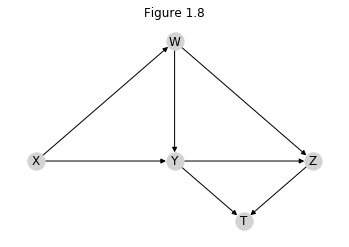

In [4]:
oy.draw(fig1_8, 
        pos={'X': (0,0), 'W': (1,1), 'Y': (1,0), 'Z': (2,0), 'T':(1.5, -.5)},
        title='Figure 1.8')

Oyster provides many pre-specified example graphs in the `oyster.example` module.  Many graphs from figures in the Primer are available as `oy.ex.primer['fig<Chapter#>_<Fig#>']`.  

If done this way, `oy.draw` will automatically resolve positions for these graphs as drawn in the book.

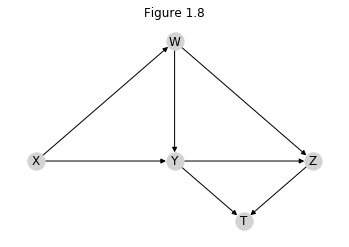

In [5]:
fig1_8_another_way = oy.ex.primer['fig1_8']
oy.draw(fig1_8_another_way, title='Figure 1.8')

Oyster provides several utility functions for examining ancestral elements of a graph:

#### a) Name all of the parents of Z

In [6]:
oy.Pa(fig1_8, 'Z')

{'W', 'Y'}

#### b) Name all of the ancestors of Z

In [7]:
oy.An(fig1_8, 'Z')

{'W', 'X', 'Y'}

*There is some disagreement in the literature about whether the set of a node's ancestors includes the node itself.  Oyster does not include it, the R package Daggity does.

#### c) Name all of the children of W

In [8]:
oy.Ch(fig1_8, 'W')

{'Y', 'Z'}

#### d) Name all of the descendants of W

In [9]:
oy.De(fig1_8, 'W')

{'T', 'Y', 'Z'}

*There is some disagreement in the literature about whether to include the node itself in its set of descendants.  Oyster does not, the R package Daggity does.

#### e) Draw all (simple) paths between X and T

In Pearl's causal lexicon, a simple path is any adjacent set of edges between two nodes.

Oyster's `paths` function returns the paths between two nodes in a graph as a collection of subgraphs, each representing a path.  The `print_path` function prints these linear subgraphs as text.

In [10]:
for path in oy.paths(fig1_8, 'X', 'T'): 
    oy.print_path(path, start='X') 

X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> Y <- W -> Z -> T
X -> Y -> T
X -> Y -> Z -> T


Or simply use the `print_paths` function:

In [11]:
oy.print_paths(fig1_8, 'X', 'T')

X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> Y <- W -> Z -> T
X -> Y -> T
X -> Y -> Z -> T


#### f) Draw all directed paths between X and T

Set keyword argument `directed=True` to show only paths that take direction into account.

In [12]:
oy.print_paths(fig1_8, 'X', 'T', directed=True)

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> Y -> T
X -> Y -> Z -> T


### Study Question 1.5.1 <a id="sq151"></a>
Suppose we have the following structural causal model (SCM).  Assume all exogenous variables $U_{i}$ are independent and that the expected value of each is 0.

\begin{equation*}
V = \{X, Y, Z\}, \hspace{20pt}
U = \{U_X, U_Y, U_Z\}, \hspace{20pt}
F = \{f_X,f_Y,f_Z\} \\
\end{equation*}
\begin{equation*}
f_X: X = U_X \\
f_Y: Y = \frac{X}{3} + U_Y \\
f_Y: Z = \frac{Y}{16} + U_Z \\
\end{equation*}

#### a) Draw the graph that complies with the model

<a id="abstraction"></a>
Pearl's definition of a causal graph states that for every variable with a structural equation, there should be an edge directed to that variable from all variables in its equation.  Importantly, ***the causal diagram graph doesn't care about the details of the structural equation.*** The relationship between two variables could be highly nonlinear, which complicates many analytic statistical methods, but at the level of abstraction of the graph, it doesn't matter.  Pearl's insight is that even at their high level, causal graphs can tell us many useful things, which the next sections get into in more detail.

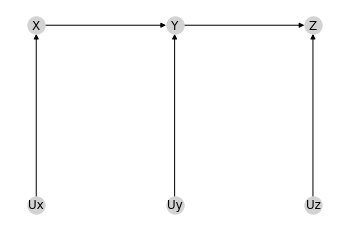

In [13]:
sq151 = oy.CausalDiagram([('Ux', 'X'), ('Uy', 'Y'), ('Uz', 'Z'), ('X', 'Y'), ('Y', 'Z')])
sq151pos = {'X': (0,0),'Y': (1,0),'Z': (2,0),'Ux': (0,-1),'Uy': (1,-1),'Uz': (2,-1),}
oy.draw(sq151, pos=sq151pos)

The rest of Study Question 1.5.1 is analytical in nature, we skip it here but many statistical python packages (such as `statsmodels`) can be used to answer or simulate the analytical questions in the Primer.

## Graphical Models and Their Applications <a id="graphsAndApps"></a>

### Study Question 2.3.1 <a id="sq231"></a>

#### a) List all pairs of variables in Figure 2.5 that are independent, conditional on the set Z = {R, V}

Since this graph is linear, I can simply print it using `print_path`. I could also have drawn it using `draw`.

In [14]:
fig2_5 = oy.CausalDiagram([('X', 'R'), ('R', 'S'), ('S', 'T'), 
                           ('U', 'T'), ('V', 'U'), ('V', 'Y')])
print('Figure 2.5\n')
oy.print_path(fig2_5, start='X')

Figure 2.5

X -> R -> S -> T <- U <- V -> Y


Two variables are independent if the path between them is blocked by the conditioned variables.  If not, the variables are possibly (actually very likely, with a few specific  exceptions) dependent. Oyster's `d_separated` function generalizes the idea of blocking to arbitrary sets of potentially independent variables and conditioners.

In [15]:
Z = {'R', 'V'}
print('Given {R,V}...')
for a,b in oy.combinations(fig2_5.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_5, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')
    else: print(f'{a} and {b} are possibly dependent.')

Given {R,V}...
T and X are independent.
T and Y are independent.
T and S are possibly dependent.
T and U are possibly dependent.
X and Y are independent.
X and S are independent.
X and U are independent.
Y and S are independent.
Y and U are independent.
S and U are independent.


<a id="d_sep_graph"></a>
Pearl defines path d-seperation in terms of graphic structures called chains (A -> B -> C), forks (A <- B -> C) and colliders (A -> B <- C):  A path is blocked by a set of nodes Z iff the path contains a chain or fork such that the middle node (B above) is in Z, or the path contains a collider such that B is *not* in Z. Two nodes X and Y are d-separated by Z iff Z contains nodes that block every path between X and Y. 

Another way to understand d-seperation is the following ***graphical algorithm***, which automatically checks every path according to Pearl's rules above and works for multi-variable sets of X, Y, and/or Z:
1. Draw the "ancestral graph" of the variables in question, i.e. the subgraph containing X, Y, Z, and their ancestors.
1. "Moralize" the ancestral graph by adding edges between all parents of a node.
1. Draw a subgraph of the moral graph, omitting nodes in Z.
1. If X and Y are now disconnected, Z d-separates X and Y.

Oyster provides a visualization for this algorithm with `d_sep_graphs`. Credit to [this worksheet](http://web.mit.edu/jmn/www/6.034/d-separation.pdf) from MIT.

X d-separated from Y by {'R', 'U'}? True


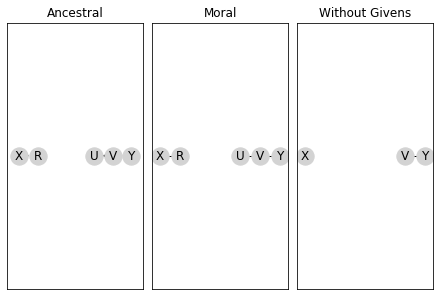

In [16]:
fig = oy.ex.primer['fig2_5']
X,Y,Z = 'X', 'Y', {'R','U'}
print(f'{X} d-separated from {Y} by {Z}? {oy.d_separated(fig, X, Y, Z)}')
oy.d_sep_graphs(fig, X, Y, Z)

#### b) For each pair of non-adjacent variables in Figure 2.5, give a set of variables that, when conditioned on, renders that pair independent.

Oyster provides a utility function `NA_pairs` for selecting the nonadjacent pairs in a graph.

Oyster's `d_separator_search` function conducts an exhaustive search for d_seperators over all possible combinations of the other nodes in a graph.  For simplicity, we select just one below.

In [17]:
for a,b in oy.NA_pairs(fig2_5):
    separators = oy.d_separator_search(fig2_5, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

S,X: {'R'}
T,X: {'S'}
X,U: set()
V,X: set()
X,Y: set()
R,T: {'S'}
R,U: set()
R,V: set()
R,Y: set()
S,U: set()
S,V: set()
S,Y: set()
V,T: {'U'}
T,Y: {'V'}
Y,U: {'V'}


`set()` means that no variables need be conditioned on to render the pair independent.  In other words, they are *marginally independent*.


See [further discussion](#impliedIndependencies) of this concept of `implied independencies` and a better, dedicated Oyster tool for finding them in study question 2.4.1 below.

#### c) List all pairs of variables in the graph of Figure 2.6 that are independent conditional on the set Z={R,P}.

Pulling the graph from `oyster.examples`...

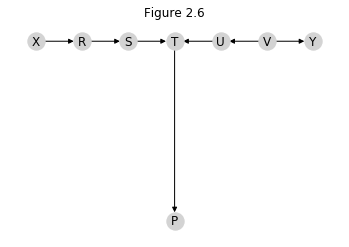

In [18]:
fig2_6 = oy.ex.primer['fig2_6']
oy.draw(fig2_6, title='Figure 2.6')

as in part a)...

In [19]:
Z = {'R', 'P'}
print('Given {R,P}...')
for a,b in oy.combinations(fig2_6.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_6, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')

Given {R,P}...
T and X are independent.
V and X are independent.
X and Y are independent.
X and S are independent.
X and U are independent.


#### d) For each pair of non-adjacent variables in Figure 2.6, give a set of variables that, when conditioned on, renders that pair independent.

as in part b) (and recalling that I show [a better way below](#impliedIndependencies) using `implied_indepenencies`).

In [20]:
for a,b in oy.NA_pairs(fig2_6):
    separators = oy.d_separator_search(fig2_6, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

S,X: {'R'}
T,X: {'S'}
P,X: {'T'}
X,U: set()
V,X: set()
X,Y: set()
R,T: {'S'}
P,R: {'T'}
R,U: set()
R,V: set()
R,Y: set()
P,S: {'T'}
S,U: set()
S,V: set()
S,Y: set()
V,T: {'U'}
T,Y: {'V'}
P,U: {'T'}
P,V: {'T'}
P,Y: {'T'}
Y,U: {'V'}


#### e) Suppose we generate data by the model described in Figure 2.5, and we fit them with the linear equation Y = a + bX + cZ. Which of the variables in the model may be chosen for Z so as to guarantee that the slope b would be equal to zero?

b = 0 iff X and Y are independent.  So in other words, which (single) variables Z d-separate X and Y?

In [21]:
[z for z in oy.d_separator_search(fig2_5, 'X', 'Y') if len(z) == 1]

[{'V'}, {'S'}, {'R'}, {'U'}]

#### f) Continuing question (e), suppose we fit the data with the equation: 

\begin{equation*}
Y = a + bX + cR + dS + eT + fP
\end{equation*}

#### which of the coefficients would be zero?

Here, the question can be reworded as "which of {X, R, S, T, P} is independent of Y, given the rest of the variables?"

In [22]:
variables = {'X', 'R', 'S', 'T', 'P'}

[v for v in variables if oy.d_separated(fig2_6, v, 'Y', variables - {v})]

['P', 'X', 'R']

### Study Question 2.4.1 <a id="sq241"></a>
Considering Figure 2.9...

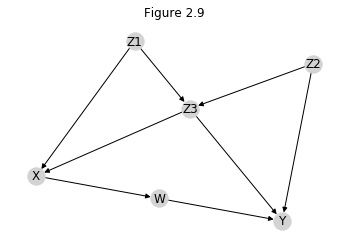

In [23]:
fig2_9 = oy.ex.primer['fig2_9']
oy.draw(fig2_9, title='Figure 2.9')

#### a) For each pair of non-adjacent nodes in this graph, find a set of variables that d-separates that pair. What does this list tell us about independencies in the data?

<a id="impliedIndependencies"></a>
If a pair of variables are d-separated, they are independent of one another, conditional on the variables that d-separate them.

This concept is important because these ***implied independancies*** represent ***testable implications*** of a model. Given a dataset and a causal diagram proporting to explain it, one can examine the if two varaibles remain correlated after controlling for factors that d-separate the variables in the causal diagram. If so, then the model is flawed.

Oyster provides a top-level function for finding displaying the independencies implied by a model.

In [24]:
oy.implied_independencies(fig2_9)

Implied independencies:
X ⫫ Y | [{'Z3', 'W', 'Z2'}, {'Z3', 'W', 'Z1'}]
Z2 ⫫ X | [{'Z3', 'Z1'}]
W ⫫ Z1 | [{'X'}]
Z3 ⫫ W | [{'X'}]
W ⫫ Z2 | [{'X'}, {'Z3', 'Z1'}]
Z1 ⫫ Y | [{'Z3', 'W', 'Z2'}, {'Z3', 'Z2', 'X'}]
Z2 ⫫ Z1 | [set()]


<a id="minsets"></a>
Note that each set in the above lists represents a minimal separating set.  So, X and Y are independent given Z1, W, and Z3.  X and Y are also independent given Z2, W, and Z3.  Z1 and Z2 are independent without controlling for any variables.  There are more seperating sets for Figure 2.9 than the minimal sets listed above, but every other set is a superset of the minimal sets, (i.e. they include at least one extraneous variable).  ***Minimal separating sets*** are an important concept because they allow independencies to be analyzed with as few covariate adjustments as possible, which among other good things means the sample sizes for each matching covariate category are larger.  Oyster provides a utility function `minimal_sets` that determines the minimal sets from a provided list of sets.

Another way to examine d-separating sets would be to run a `d_separator_search` for each nonadjacent pair. This is what `implied_independancies` does behind the scenes, returning only the `minimal_sets`.

In [25]:
all_X_Y_d_separators = oy.d_separator_search(fig2_9, 'X', 'Y')
print('d-separating sets for X ⫫ Y in Figure 2.9:')
print(f'All: {all_X_Y_d_separators}')
print(f'Minimal: {oy.minimal_sets(all_X_Y_d_separators)}')

d-separating sets for X ⫫ Y in Figure 2.9:
All: [{'Z3', 'W', 'Z2'}, {'Z3', 'W', 'Z1'}, {'Z3', 'W', 'Z1', 'Z2'}]
Minimal: [{'Z3', 'W', 'Z2'}, {'Z3', 'W', 'Z1'}]


#### b) Repeat question (a) assuming that only variables in the set {Z3,W,X,Z1} can be measured.

Now, instead of taking the minimal sets as is done with `implied_independencies`, we will run an exhaustive `d_separator_search` against nonadjacent pairs, and filter the results such that the seperating sets include only measurable variables, and only for measurable pairs.

In [26]:
measurable = {'Z3','W','X','Z1'}

all_d_seps_for_measurable_pairs = [(a,b, oy.d_separator_search(fig2_9, a, b))
                                   for a,b in oy.NA_pairs(fig2_9) 
                                   if a in measurable and b in measurable]

for (a,b,sep) in all_d_seps_for_measurable_pairs:
    print(f'{a} ⫫ {b} | {list(filter(lambda s: s < measurable, sep))}')

W ⫫ Z1 | [{'X'}, {'Z3', 'X'}]
Z3 ⫫ W | [{'X'}, {'Z1', 'X'}]


#### c) For each pair of non-adjacent nodes in the graph, determine whether they are independent conditional on all other variables.

In [27]:
for (a,b) in oy.NA_pairs(fig2_9):
    all_other_variables = fig2_9.nodes - {a} - {b}
    ind = oy.d_separated(fig2_9, a, b, all_other_variables)
    if ind: print(f'{a} ⫫ {b} | {all_other_variables}')

X ⫫ Y | {'Z3', 'W', 'Z2', 'Z1'}
Z2 ⫫ X | {'Z3', 'W', 'Z1', 'Y'}
W ⫫ Z1 | {'Z3', 'Z2', 'X', 'Y'}
Z1 ⫫ Y | {'Z3', 'W', 'Z2', 'X'}


#### d) For every variable V in the graph, find a minimal set of nodes that renders V independent of all other variables in the graph.

An important result from Bayesian Network theory is that V is independent of all other variables in the graph given the set of V's parents, V's children, and all the other parents of V's children.  This set is also guaranteed to be minimal.  This set is known as a variable's ***Markov Blanket***, and is accessed by the `MB` utility function.

In [28]:
for node in fig2_9.nodes:
    mb = oy.MB(fig2_9, node)
    print(f'{node} ⫫ {fig2_9.nodes - mb} | {mb}')

X ⫫ {'Z2', 'X', 'Y'} | {'Z3', 'W', 'Z1'}
W ⫫ {'W', 'Z1'} | {'Z3', 'Z2', 'X', 'Y'}
Y ⫫ {'Z1', 'X', 'Y'} | {'Z3', 'W', 'Z2'}
Z1 ⫫ {'W', 'Z1', 'Y'} | {'Z3', 'Z2', 'X'}
Z3 ⫫ {'Z3'} | {'Z1', 'W', 'Z2', 'X', 'Y'}
Z2 ⫫ {'Z2', 'X'} | {'Z3', 'W', 'Z1', 'Y'}


#### e) Suppose we wish to estimate the value of Y from measurements taken on all other variables in the model. Find the smallest set of variables that would yield as good an estimate as before.

<a id="mb"></a>
This is an important application of the [Markov Blanket](https://en.wikipedia.org/wiki/Markov_blanket). As a corollary from the above discussion, a variable V's Markov Blanket is the minimal set of variables that contain the knowledge needed to predict V.

In [29]:
oy.MB(fig2_9, 'Y')

{'W', 'Z2', 'Z3'}

Alternatively, if you were a glutton for punishment you could take the minimal set of the intersection of the sets of sets that d-separate Y from every nonadjacent node:

In [30]:
separating_sets_for_NA_nodes = [oy.d_separator_search(fig2_9, 'Y', node)
                                for node in oy.NA(fig2_9, 'Y')]

intersection = {frozenset(s) for s in separating_sets_for_NA_nodes[0]}
for node in separating_sets_for_NA_nodes[1:]:
    intersection.intersection_update({frozenset(s) for s in node})

[set(s) for s in intersection]

[{'W', 'Z2', 'Z3'}]

#### f) Repeat Question (e) assuming that we wish to estimate the value of Z2

In [31]:
oy.MB(fig2_9, 'Z2')

{'W', 'Y', 'Z1', 'Z3'}

#### g) Suppose we wish to predict the value of Z2 from measurements of Z3. Would the quality of our prediction improve if we add measurement of W? Explain.

In other words...is W d-separated from Z2, given Z3?

In [32]:
oy.d_separated(fig2_9, 'Z2', 'W', 'Z3')

False

<a id="variableSelection"></a>
Answer: "Probably, but...".  W is not d-separated from Z2 given Z3.  If it *were* d-separated (i.e. conditionally independent, given Z3), then adding it to the model would not add additional information and the answer would be a definite "No."  Since in fact W is not d-separated from Z2 given Z3 (i.e. it remains correlated), including it will improve (in-sample) prediction, at least as measured by $R^{2}$ ... but the improvement will not necessarily be worth the cost of making the model less parsimonious.

To summarize the value of graphical analysis for ***variable selection***: a model implies that some variables (those that are d-separated, a.k.a independent of the variable to be predicted, conditional on the other variables being measured), are certainly not worth including when making predictions.  Variables that grahical analysis shows are d-connected may or may not have value.

### Study Question 2.5.1 <a id="sq251"></a>

Which of the arrows in Figure 2.9 can be reversed without being detected by any statistical test?

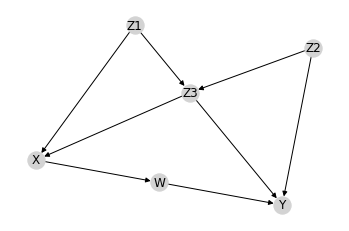

In [35]:
oy.draw(fig2_9) # Still using fig2_9 as above

The "statistical tests" mentioned above check for independencies between variables. So in other words, the question asks: How many graphs can be formed from reversing the direction of any edge in Figure 2.9, while stil implying the same set of independencies?  

This set of graphs with the same skeleton and implied independencies is called an ***equivalence class.*** Oyster provides a function for the `equivalence_class_size` of a given causal diagram.

In [36]:
oy.equivalence_class_size(fig2_9)

1

An equivalence class size of 1 means that, in Figure 2.9, *no arrows* can be reversed without the resulting graph having a different set of implied independencies.  It's a trick question!

The ***Complete Partial DAG (CPDAG)*** is a related concept to equivalence class.  The CPDAG is a partially-directed graph, where edges that are *compelled* to have a certain direction based on implied independencies are represented as normal, but edges that can be reversed are shown as undirected (or, equivalently, with arrows at both ends).  CPDAGs summarize an equivalence class in a single graph; pick an arbirary direction for each undirected edge and the reslting graph is a member of the same equivalence class.

CPDAGs and equivalence classes have two important applications:
1) In the field of ***causal search***, a dataset is interrogated for any independence relationships between variables, and the resulting independencies can be used to generate a graph that explains the data.  Think of this as going in reverse from how we've considered graphs so far: where so far we have we hyppothesized a causal diagram that can verified against the data, causal search takes the data and generates a graph that fits.  The catch is that these causal search methods can only go so far, because there might be several graphs that explain the data, with arrows in different directions so long as they don't violate an independence in the data.
2) CPDAG's summarize the valid ***alternate hypotheses*** that could correctly explain a dataset, in addition to a given valid causal model.  In many fields it pays to be aware of the fact that different explainations could exist that are just as consistent with the collected data; articulating these alternatives is a starting point for devising followon experiments that can focus on deciding between alternative models.

Oyster's `dag_to_cpdag` function returns a CPDAG from a given DAG.  As expected, the CPDAG for Figure 2.9 is the same as Figure 2.9; all of the edges are compelled to one direction by Figure 2.9's implied independencies.

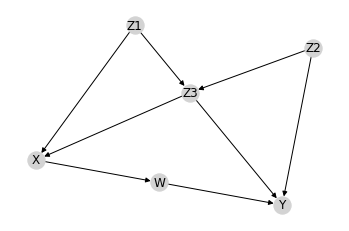

In [37]:
oy.draw(oy.dag_to_cpdag(fig2_9), pos=oy.ex.pos[fig2_9])

For a more illuminating example, let's look at Figure 1.8. Oyster also provides a visualization function `draw_cpdag` tht draws the graph and it's CPDAG side-by-side.

In [38]:
oy.draw_cpdag(fig1_8)

TypeError: draw_cpdag() missing 1 required positional argument: 'pos'